# Flappy Bird - Proximal Policy Optimization

In this notebook, we will implement a **Proximal Policy Optimization (PPO)** for the Flappy Bird game.



## Index

- [1. Initial Setup](#1.-Initial-Setup)
- [2. Check the Gym environment](#2-check-the-gym-environment)
- [3. Define custom functions](#3-define-custom-functions)
- [4. Training the RL agent](#4-training-the-rl-agent)
  - [4.1 Agent - Training](#4.1-agent-training)
  - [4.1 Agent - Scores](#4.1-agent-scores)
- [5. Save agent](#5-save-agent)
- [6. Load agent](#6-load-agent)
- [7. Test trained agent](#7-test-trained-agent)
- [8. Conclusions](#8-conclusions)

## References

- [[1707.06347] Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)

## 1. Initial Setup

Add project root directory to the path.

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent))

Imports modules

In [2]:
import numpy as np
import flappy_bird_gym
import matplotlib.pyplot as plt

from src.trainer import Trainer
from src.utils import play_env, aggregate_list
from src.ppo.agent import Agent
from src.ppo.config import AgentConfig

seed = 1993

## 2. Check the Gym environment

Before we start, we need to check how the environment works. For this, we will check the action space and observation space.

In [3]:
env = flappy_bird_gym.make("FlappyBird-v0")

env.seed(seed)

action_size = env.action_space.n
state_size = env.observation_space.shape[0]

print(f"Number of actions: {action_size}")
print(f"Sample state shape: {env.observation_space.shape}")
print(f"Sample state: {env.reset()}")

Number of actions: 2
Sample state shape: (2,)
Sample state: [ 1.65625   -0.0546875]


## 3. Define custom functions

In the next cell, we define a `custom_prep_state()` function that can be used to preprocess the state of the game.

We will replace the original `prep_state()` (that does nothing) with this function.

In [4]:
def custom_prep_state(state: np.ndarray) -> np.ndarray:
    """
    Custom preprocessing of the state.

    This function replaces the default preprocessing of the state of the agent (prep_state())

    Args:
    - state: State to preprocess.

    Returns:
    - Preprocessed state.
    """
    return state.reshape(1, -1)

sample_state = custom_prep_state(env.reset())
print(f"Shape of state: {sample_state.shape}")
sample_state

Shape of state: (1, 2)


array([[ 1.65625   , -0.01171875]])

## 4. Training the RL agent

First, we will instantiate the AgentConfig that defines the hyperparameters of our PPO Agent.

In [5]:
params = AgentConfig(
    state_size=sample_state.shape[1],
    action_size=action_size,
    seed=seed,
    model_dir="../models/PPO"
)

params.dict()

{'state_size': 2,
 'action_size': 2,
 'seed': 1993,
 'memory_size': 100000,
 'nb_hidden': (64, 64),
 'gamma': 0.99,
 'lam': 0.97,
 'target_kl': 0.01,
 'policy_lr': 0.0003,
 'value_lr': 0.001,
 'train_policy_iters': 10,
 'train_value_iters': 10,
 'clip_ratio': 0.2,
 'epsilon_enabled': True,
 'epsilon_start': 1.0,
 'epsilon_end': 0.01,
 'epsilon_decay': 0.995,
 'model_dir': '../models/PPO'}

Now, we will define the trainer parameters.

In [6]:
trainer_args = {
    "n_episodes": 60000,
    "print_range": 1000,
    "early_stop": 120,
    "verbose": True,
}

### 4.1 Agent - Training

In [14]:
%%time

agent = Agent(**params.dict())

# Add our custom prep_state function to the agent
agent.prep_state = custom_prep_state

trainer = Trainer(agent=agent, env=env, **trainer_args)
trainer.run(logs_callback=agent.logs)

Episode 1000	Avg Score: 98.79	Epsilon: 0.01
Episode 2000	Avg Score: 101.32	Epsilon: 0.01
Episode 3000	Avg Score: 101.00	Epsilon: 0.01
Episode 4000	Avg Score: 100.68	Epsilon: 0.01
Episode 5000	Avg Score: 100.69	Epsilon: 0.01
Episode 6000	Avg Score: 101.00	Epsilon: 0.01
Episode 7000	Avg Score: 101.00	Epsilon: 0.01
Episode 8000	Avg Score: 101.00	Epsilon: 0.01
Episode 9000	Avg Score: 101.00	Epsilon: 0.01
Episode 10000	Avg Score: 101.01	Epsilon: 0.01
Episode 11000	Avg Score: 101.03	Epsilon: 0.01
Episode 12000	Avg Score: 101.01	Epsilon: 0.01
Episode 13000	Avg Score: 101.07	Epsilon: 0.01
Episode 14000	Avg Score: 102.96	Epsilon: 0.01
Episode 15000	Avg Score: 102.08	Epsilon: 0.01
Episode 16000	Avg Score: 102.39	Epsilon: 0.01
Episode 17000	Avg Score: 103.74	Epsilon: 0.01
Episode 18000	Avg Score: 103.05	Epsilon: 0.01
Episode 19000	Avg Score: 103.26	Epsilon: 0.01
Episode 20000	Avg Score: 103.01	Epsilon: 0.01
Episode 21000	Avg Score: 103.65	Epsilon: 0.01
Episode 22000	Avg Score: 103.75	Epsilon: 0.0

True

### 4.2 Agent - Scores

In [51]:
print(f"Best score: {trainer.best_score} - (episode: {trainer.best_episode})")
print(f"Last score: {trainer.last_score} - (episode: {trainer.last_episode})")

Best score: 120.534 - (episode: 36029)
Last score: 120.534 - (episode: 36029)


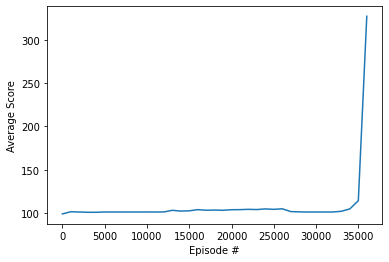

In [15]:
avg_scores = aggregate_list(trainer.scores, trainer_args["print_range"])
x = [i*trainer_args["print_range"] for i in range(len(avg_scores))]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, avg_scores)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()

## 5. Save agent

In [ ]:
agent.save_model(params.model_dir)

## 6. Load agent

In [ ]:
del agent

In [7]:
agent = Agent(**params.dict())
agent.prep_state = custom_prep_state
agent.epsilon_enabled = False

agent.load_model(params.model_dir)

## 7. Test trained agent

In [9]:
env = flappy_bird_gym.make("FlappyBird-v0")
env.seed(seed)

for i in range(10):
    play_env(agent, env, fps=30, render=True)

Score: 840.00
Score: 692.00
Score: 174.00
Score: 527.00
Score: 342.00
Score: 506.00
Score: 770.00
Score: 897.00
Score: 367.00
Score: 1062.00


## 8. Conclusions

The Proximal Policy Optimization (PPO) algorithm is a powerful algorithm that can be used to learn playing the Flappy Bird game.

We achieved good results with the PPO algorithm after training the agent for 36,000 episodes.